In [1]:
import lore.io
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

oak in development on jianhuitian@Jianhui-C02XD23FJGH5 with Python 3.7.3 & Lore 0.8.3


/Users/jianhuitian/.pyenv/versions/3.7.3/envs/oak/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
df = lore.io.snowflake.dataframe("""
With region_size as (
select delivery_completed_day_local::date as date,
region_id,
region_name,
launch_date, 
num_deliveries,
num_deliveries_r7d,
region_maturity,
region_size
from fact_region_maturity_size_daily
where delivery_completed_day_local::date = convert_timezone('UTC', 'America/Los_Angeles' , current_timestamp)::date - 2
order by num_deliveries_r7d desc, region_id, date
),

supply_states as (
select zone_id, 
  avg(case when supply_balance_state = 'oversupplied' then 1 
       when supply_balance_state = 'balanced' then 0
       else -1 end) as supply_score
  from analysts.supply_states_zone
  where True
  and week_start >= date_trunc('week', convert_timezone('UTC', 'America/Los_Angeles', current_timestamp))::date - 14
  group by 1
  order by 1
),

zone_size as (
select zs.zone_id, zone_name, region_id, region_name, ss.supply_score, num_deliveries, num_deliveries_r7d, zone_size 
from fact_zone_maturity_size_daily zs
join supply_states ss on ss.zone_id = zs.zone_id
where delivery_completed_day_local::date = convert_timezone('UTC', 'America/Los_Angeles' , current_timestamp)::date - 2
order by num_deliveries_r7d desc
),

sum_zone_size as (
select region_id,
  sum(num_deliveries_r7d) as region_tot_r7d
from zone_size
group by 1
),

region_supply_state as (
select zs.region_id, 
  --zs.zone_id, 
  --zs.num_deliveries_r7d as zone_del_r7d,
  szs.region_tot_r7d, 
  --ss.supply_score, 
  sum(ss.supply_score * zs.num_deliveries_r7d / (szs.region_tot_r7d + 0.001)) as wt_supply_score,
  sum(zs.num_deliveries_r7d / (szs.region_tot_r7d + 0.001)) as wt_sum
from zone_size zs
join supply_states ss on ss.zone_id = zs.zone_id
join sum_zone_size szs on szs.region_id = zs.region_id
group by 1, 2
order by 2 desc
),

region_lost_demand as (
select -- dem.date, 
  z.region_id,
  -- dem.customer_zone_id,
  sum(dem.total_lost_demand) as del_ld,
  sum(dem.deliveries_created) as del_created,
  round(sum(dem.total_demand), 1) as demand,
  case when sum(dem.total_demand) > 0 then round(sum(dem.total_lost_demand) / sum(dem.total_demand), 3) 
        else 1 end as ld_ratio
from demand_estimates_metrics dem
join zones z on z.id = dem.customer_zone_id
where date >= convert_timezone('UTC', 'America/Los_Angeles' , current_timestamp)::date - 15
and date <= convert_timezone('UTC', 'America/Los_Angeles' , current_timestamp)::date - 2
and deleted_ind = 'N'
group by 1
), 

rain_prediction as (
select
wd.zone_id as zone_id
, z.region_id
, convert_timezone('UTC', z.time_zone_name, wd.starts_at)::date as date
, hour(convert_timezone('UTC', z.time_zone_name, wd.starts_at)) as hour  --starts_at is UTC
, wd.starts_at
, wd.ends_at
, precipitation_intensity as rain_level
, precipitation_probability as rain_prob
, wd.updated_at
, wd.id
from weather_data wd
join zones z on z.id = wd.zone_id
WHERE 1=1
AND interval = 'hourly'
AND precipitation_type = 'rain'
AND convert_timezone('UTC', z.time_zone_name, wd.starts_at)::date >= convert_timezone('UTC', 'America/Los_Angeles' , current_timestamp)::date - 367
AND convert_timezone('UTC', z.time_zone_name, wd.starts_at)::date <= convert_timezone('UTC', 'America/Los_Angeles' , current_timestamp)::date - 336
AND (z.name not ilike '%pickup only%' AND z.name not ilike '%cnc%'
     AND z.name not ilike '%pickuponly%' and z.name not ilike '%test%')
qualify row_number() over (partition by wd.zone_id, starts_at order by wd.updated_at desc) = 3
order by wd.zone_id, wd.starts_at desc
),

region_rain as (
select
 z.region_id
--, r.name as region_name
--, z.state
--, z.id as zone_id
--, z.name as z_name
--, z.time_zone_name
--, wd.summary as event_name
--, rp.date
--, rp.hour
--, wd.starts_at
--, wd.ends_at
, round(sum(wd.precipitation_intensity), 2) as monthly_rain
--, wd.precipitation_probability
--, wd.precipitation_type
--, wd.temperature
--, wd.wind_speed
--, wd.pressure
--, wd.visibility
from weather_data wd
join zones z on wd.zone_id = z.id
join regions r on r.id = z.region_id
join rain_prediction rp on rp.id = wd.id
where 1=1
AND convert_timezone('UTC', z.time_zone_name, wd.starts_at)::date >= convert_timezone('UTC', 'America/Los_Angeles' , current_timestamp)::date - 367
AND convert_timezone('UTC', z.time_zone_name, wd.starts_at)::date <= convert_timezone('UTC', 'America/Los_Angeles' , current_timestamp)::date - 336
AND rp.updated_at is not null
AND wd.precipitation_intensity >= 0.0
AND wd.precipitation_probability > 0.0
AND wd.summary ilike '%rain%'
AND (r.name not ilike '%pickup only%' AND r.name not ilike '%cnc%'
     AND r.name not ilike '%pickuponly%' and r.name not ilike '%test%')
group by 1
order by 2 desc
)

select rld.region_id,
rs.region_name,
rld.ld_ratio,
rss.wt_supply_score,
case when rr.monthly_rain is not null then rr.monthly_rain
     else 0 end as monthly_rain,
(rld.demand / 2) as weekly_demand,
rs.num_deliveries_r7d as region_del_r7d,
rss.region_tot_r7d as region_tot_r7d_2
from region_lost_demand rld
join region_supply_state rss on rld.region_id = rss.region_id
join region_size rs on rs.region_id = rld.region_id
left join region_rain rr on rr.region_id = rld.region_id
""")

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


In [3]:
df.to_csv('regional_info.csv', index=False)

Lost demand >= 0.2 couts:
6


(array([180., 253.,  87.,  33.,   8.,   5.,   3.,   4.,   0.,   2.]),
 array([0.014 , 0.0295, 0.045 , 0.0605, 0.076 , 0.0915, 0.107 , 0.1225,
        0.138 , 0.1535, 0.169 ]),
 <a list of 10 Patch objects>)

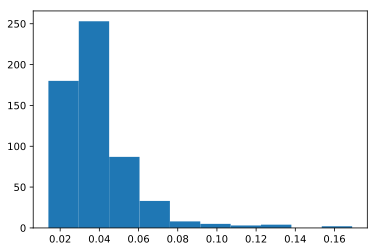

In [4]:
print('Lost demand >= 0.2 couts:')
print(len(df[df['ld_ratio'] >= 0.2]))
plt.hist(df[df['ld_ratio'] < 0.2]['ld_ratio'])

In [5]:
df.head()

,region_id,region_name,ld_ratio,wt_supply_score,monthly_rain,weekly_demand,region_del_r7d,region_tot_r7d_2
0,7,Los Angeles,0.030,0.332028,0.00,324780.05,315177,315177
1,6,NYC,0.060,-0.430146,85.29,212168.80,190469,190469
2,1,San Francisco Bay Area,0.033,0.679586,0.00,176829.00,165689,165689
3,24,Southeast Florida,0.032,0.235638,111.83,156735.85,161523,161523
4,15,Atlanta,0.037,0.444860,122.57,147228.00,155939,155939


In [6]:
df_threshold = df[['ld_ratio', 'region_del_r7d', 'wt_supply_score', 'monthly_rain']]\
                .quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [7]:
df_threshold

,ld_ratio,region_del_r7d,wt_supply_score,monthly_rain
0.1,0.024,98.0,-0.999995,0.08
0.2,0.027,236.0,-0.442218,1.13
0.3,0.029,426.0,0.000000,2.21
0.4,0.032,627.0,0.000000,2.82
0.5,0.034,975.0,0.094456,4.07
0.6,0.037,1694.0,0.371531,5.22
0.7,0.041,3204.0,0.918557,7.10
0.8,0.049,6132.0,0.999991,12.02
0.9,0.061,14482.0,0.999998,21.61


In [8]:
df_threshold.iloc[8]

ld_ratio               0.061000
region_del_r7d     14482.000000
wt_supply_score        0.999998
monthly_rain          21.610000
Name: 0.9, dtype: float64

In [9]:
df_threshold.iloc[8]['ld_ratio']

0.061

In [10]:
df.isnull().sum()

region_id           0
region_name         0
ld_ratio            0
wt_supply_score     0
monthly_rain        0
weekly_demand       0
region_del_r7d      0
region_tot_r7d_2    0
dtype: int64

In [11]:
# Create Tiers For Different Features

df['ld_tier'] = df['ld_ratio'].map(lambda x: 1 if x < df_threshold.iloc[0]['ld_ratio'] else 
                                             2 if x < df_threshold.iloc[1]['ld_ratio'] else 
                                             3 if x < df_threshold.iloc[2]['ld_ratio'] else 
                                             4 if x < df_threshold.iloc[3]['ld_ratio'] else 
                                             5 if x < df_threshold.iloc[4]['ld_ratio'] else 
                                             6 if x < df_threshold.iloc[5]['ld_ratio'] else 
                                             7 if x < df_threshold.iloc[6]['ld_ratio'] else 
                                             8 if x < df_threshold.iloc[7]['ld_ratio'] else 
                                             9 if x < df_threshold.iloc[8]['ld_ratio'] else 
                                             10)

df['size_tier'] = df['region_del_r7d'].map(lambda x: 1 if x > df_threshold.iloc[8]['region_del_r7d'] else 
                                             2 if x > df_threshold.iloc[7]['region_del_r7d'] else 
                                             3 if x > df_threshold.iloc[6]['region_del_r7d'] else 
                                             4 if x > df_threshold.iloc[5]['region_del_r7d'] else 
                                             5 if x > df_threshold.iloc[4]['region_del_r7d'] else 
                                             6 if x > df_threshold.iloc[3]['region_del_r7d'] else 
                                             7 if x > df_threshold.iloc[2]['region_del_r7d'] else 
                                             8 if x > df_threshold.iloc[1]['region_del_r7d'] else 
                                             9 if x > df_threshold.iloc[0]['region_del_r7d'] else 
                                             10)

df['rain_tier'] = df['monthly_rain'].map(lambda x: 1 if x > df_threshold.iloc[8]['monthly_rain'] else 
                                             2 if x > df_threshold.iloc[7]['monthly_rain'] else 
                                             3 if x > df_threshold.iloc[6]['monthly_rain'] else 
                                             4 if x > df_threshold.iloc[5]['monthly_rain'] else 
                                             5 if x > df_threshold.iloc[4]['monthly_rain'] else 
                                             6 if x > df_threshold.iloc[3]['monthly_rain'] else 
                                             7 if x > df_threshold.iloc[2]['monthly_rain'] else 
                                             8 if x > df_threshold.iloc[1]['monthly_rain'] else 
                                             9 if x > df_threshold.iloc[0]['monthly_rain'] else 
                                             10)

In [12]:
# Sort by rain first, since rain should be the first factor for controled selection as rain varies a lot.
# Sort by region size second.
# Sort by ld last, since ld different is small. 

df.sort_values(by=['rain_tier', 'size_tier', 'ld_tier', 'wt_supply_score'], 
               ascending=[True, True, True, False],
               inplace=True)
df.reset_index(inplace=True, drop=True)

In [13]:
df.head(30)

,region_id,region_name,ld_ratio,wt_supply_score,monthly_rain,weekly_demand,region_del_r7d,region_tot_r7d_2,ld_tier,size_tier,rain_tier
0,99,Treasure Coast,0.022,0.353193,24.47,12569.90,14955,14955,1,1,1
1,74,Southwest Florida,0.024,0.480755,54.75,21027.40,24006,24006,2,1,1
2,80,"Kansas City, KS",0.024,0.120529,33.40,29644.95,34473,34473,2,1,1
3,12,Seattle,0.027,0.593976,54.54,79036.15,76333,76333,3,1,1
4,16,Houston,0.030,0.761849,73.10,62421.20,61270,61270,4,1,1
5,91,Greenville,0.031,0.581854,21.78,12474.40,15326,15326,4,1,1
6,37,Baltimore,0.030,0.489493,52.22,60403.80,63006,63006,4,1,1
7,50,Nashville,0.031,-0.224618,59.63,37481.70,40905,40905,4,1,1
8,44,Tampa,0.033,0.273568,90.09,90399.40,104069,104069,5,1,1
9,25,St. Louis,0.033,0.239482,25.06,47105.50,54606,54595,5,1,1


In [14]:
import random
random.randint(0, 1)

1

In [15]:
sum([random.randint(0,1) for i in range(5000)])

2566

In [16]:
# Assign control or treatment group

df['treatment'] = 0

for i in range(len(df) // 2):
    seed = random.randint(0, 1)
    if seed == 0:
        df.loc[i * 2, ['treatment']] = 1
    else:
        df.loc[i * 2 + 1, ['treatment']] = 1

In [17]:
df.head(10)

,region_id,region_name,ld_ratio,wt_supply_score,monthly_rain,weekly_demand,region_del_r7d,region_tot_r7d_2,ld_tier,size_tier,rain_tier,treatment
0,99,Treasure Coast,0.022,0.353193,24.47,12569.90,14955,14955,1,1,1,1
1,74,Southwest Florida,0.024,0.480755,54.75,21027.40,24006,24006,2,1,1,0
2,80,"Kansas City, KS",0.024,0.120529,33.40,29644.95,34473,34473,2,1,1,1
3,12,Seattle,0.027,0.593976,54.54,79036.15,76333,76333,3,1,1,0
4,16,Houston,0.030,0.761849,73.10,62421.20,61270,61270,4,1,1,0
5,91,Greenville,0.031,0.581854,21.78,12474.40,15326,15326,4,1,1,1
6,37,Baltimore,0.030,0.489493,52.22,60403.80,63006,63006,4,1,1,1
7,50,Nashville,0.031,-0.224618,59.63,37481.70,40905,40905,4,1,1,0
8,44,Tampa,0.033,0.273568,90.09,90399.40,104069,104069,5,1,1,0
9,25,St. Louis,0.033,0.239482,25.06,47105.50,54606,54595,5,1,1,1


In [18]:
sum(df['treatment'])

290

In [19]:
print(df[df['treatment'] == 1]['region_id'].unique().tolist())

[99, 80, 91, 37, 25, 275, 48, 29, 89, 107, 15, 36, 21, 6, 11, 202, 5, 64, 45, 109, 82, 351, 333, 451, 139, 134, 152, 400, 466, 116, 72, 18, 63, 98, 104, 131, 121, 70, 110, 146, 141, 352, 106, 409, 605, 206, 313, 230, 153, 177, 501, 498, 486, 429, 477, 453, 513, 408, 23, 156, 189, 67, 204, 148, 90, 97, 144, 132, 137, 317, 102, 384, 446, 484, 164, 350, 53, 284, 459, 213, 518, 343, 286, 291, 456, 534, 599, 85, 73, 195, 173, 277, 369, 353, 154, 198, 111, 105, 390, 600, 574, 285, 549, 462, 576, 538, 622, 405, 667, 530, 669, 488, 684, 668, 474, 432, 315, 203, 288, 298, 96, 359, 101, 532, 338, 358, 507, 531, 461, 497, 444, 536, 503, 374, 645, 670, 578, 436, 455, 640, 387, 674, 619, 678, 696, 210, 149, 278, 194, 193, 158, 324, 460, 290, 537, 301, 319, 480, 469, 516, 399, 631, 519, 535, 547, 238, 561, 591, 542, 570, 596, 389, 654, 609, 186, 93, 308, 525, 299, 511, 450, 310, 504, 470, 610, 282, 550, 620, 435, 212, 423, 647, 383, 585, 613, 329, 672, 624, 431, 452, 648, 440, 662, 125, 349, 60, 20,

In [20]:
print(df[df['treatment'] == 0]['region_id'].unique().tolist())

[74, 12, 16, 50, 44, 24, 77, 28, 49, 46, 4, 100, 179, 123, 35, 2, 491, 108, 113, 226, 79, 129, 52, 170, 178, 467, 176, 407, 457, 119, 22, 19, 3, 118, 38, 66, 65, 281, 219, 150, 242, 197, 115, 200, 160, 117, 128, 120, 327, 499, 526, 57, 490, 464, 454, 279, 438, 590, 30, 208, 135, 289, 222, 122, 205, 87, 145, 168, 169, 167, 280, 199, 196, 174, 94, 367, 240, 355, 373, 443, 372, 475, 482, 527, 595, 412, 639, 92, 126, 559, 201, 187, 61, 344, 541, 483, 165, 283, 311, 360, 391, 294, 312, 103, 540, 606, 430, 529, 614, 644, 406, 496, 524, 388, 589, 675, 88, 699, 220, 95, 71, 332, 445, 337, 489, 302, 479, 545, 565, 304, 510, 628, 514, 481, 580, 602, 623, 375, 493, 615, 633, 523, 544, 679, 658, 142, 112, 478, 287, 370, 83, 181, 473, 533, 339, 441, 316, 398, 305, 356, 442, 621, 439, 539, 386, 666, 671, 582, 548, 584, 543, 607, 583, 162, 207, 307, 232, 188, 306, 487, 296, 485, 472, 215, 552, 211, 564, 434, 449, 562, 465, 557, 625, 575, 433, 340, 641, 512, 652, 611, 637, 680, 603, 114, 127, 235, 328

In [21]:
df.to_csv('20210831_apollo_rain_randomization.csv', index=False)

In [22]:
df_treatment_ld = lore.io.snowflake.dataframe("""
select dem.date, 
  -- z.region_id,
  -- dem.customer_zone_id,
  sum(dem.total_lost_demand) as del_ld,
  sum(dem.deliveries_created) as del_created,
  round(sum(dem.total_demand), 1) as demand,
  case when sum(dem.total_demand) > 0 then round(sum(dem.total_lost_demand) / sum(dem.total_demand), 3) 
        else 1 end as ld_ratio
from demand_estimates_metrics dem
join zones z on z.id = dem.customer_zone_id
where date >= convert_timezone('UTC', 'America/Los_Angeles' , current_timestamp)::date - 57
and date <= convert_timezone('UTC', 'America/Los_Angeles' , current_timestamp)::date - 2
and z.region_id in (74, 12, 25, 22, 24, 48, 19, 29, 28, 46, 4, 100, 36, 179, 35, 123, 5, 64, 113, 108, 226, 150, 129, 333, 451, 134, 176, 400, 457, 91, 23, 72, 3, 208, 104, 38, 65, 110, 204, 242, 141, 170, 409, 178, 605, 128, 352, 327, 230, 526, 501, 443, 490, 454, 429, 279, 513, 408, 116, 156, 189, 205, 148, 144, 97, 137, 173, 168, 169, 317, 280, 196, 174, 541, 164, 350, 105, 355, 213, 372, 518, 482, 527, 534, 412, 474, 524, 118, 145, 559, 187, 240, 384, 344, 367, 198, 165, 101, 360, 445, 337, 103, 489, 576, 291, 461, 430, 622, 631, 529, 481, 644, 530, 455, 589, 679, 92, 126, 210, 203, 288, 96, 332, 311, 574, 312, 358, 302, 507, 304, 531, 539, 514, 503, 602, 578, 669, 436, 671, 674, 496, 684, 619, 678, 583, 142, 112, 71, 171, 370, 158, 525, 473, 441, 316, 450, 480, 211, 550, 516, 399, 374, 647, 587, 238, 640, 582, 591, 389, 584, 570, 596, 607, 696, 162, 195, 93, 181, 308, 299, 324, 296, 504, 215, 500, 398, 610, 282, 510, 449, 435, 465, 557, 625, 585, 433, 672, 476, 611, 452, 597, 608, 654, 127, 235, 149, 328, 318, 300, 505, 448, 322, 326, 368, 588, 495, 577, 320, 292, 581, 78, 598, 677, 575, 649, 380, 357, 653, 661, 437, 323, 660, 81, 234, 138, 227, 228, 218, 321, 221, 403, 520, 554, 553, 411, 556, 551, 642, 579, 428, 382, 558, 303, 627, 650, 330, 414, 381, 568, 636, 612, 39, 54, 1, 159, 124, 130, 191, 155, 184, 161, 223, 241, 229, 237, 364, 347, 361, 395, 365, 342, 394, 417, 522, 404, 586, 706, 656, 567, 494)
and deleted_ind = 'N'
group by 1
""")

In [23]:
print('Mean:')
print(df_treatment_ld.ld_ratio.mean())
print('\nSTD:')
print(df_treatment_ld.ld_ratio.std())

Mean:
0.036196428571428574

STD:
0.006713404888341324


In [24]:
df_control_ld = lore.io.snowflake.dataframe("""
select dem.date, 
  -- z.region_id,
  -- dem.customer_zone_id,
  sum(dem.total_lost_demand) as del_ld,
  sum(dem.deliveries_created) as del_created,
  round(sum(dem.total_demand), 1) as demand,
  case when sum(dem.total_demand) > 0 then round(sum(dem.total_lost_demand) / sum(dem.total_demand), 3) 
        else 1 end as ld_ratio
from demand_estimates_metrics dem
join zones z on z.id = dem.customer_zone_id
where date >= convert_timezone('UTC', 'America/Los_Angeles' , current_timestamp)::date - 57
and date <= convert_timezone('UTC', 'America/Los_Angeles' , current_timestamp)::date - 2
and z.region_id in (99, 80, 37, 16, 275, 77, 44, 50, 49, 107, 15, 18, 2, 6, 21, 202, 11, 109, 219, 45, 131, 79, 82, 52, 139, 152, 467, 407, 466, 70, 89, 63, 491, 98, 66, 281, 121, 67, 289, 351, 197, 106, 160, 222, 206, 120, 153, 446, 177, 498, 57, 486, 464, 477, 456, 453, 438, 590, 119, 30, 135, 146, 117, 122, 87, 90, 132, 200, 115, 167, 313, 102, 484, 94, 499, 53, 284, 459, 373, 391, 475, 343, 462, 595, 639, 599, 675, 85, 315, 277, 61, 199, 478, 353, 154, 483, 283, 460, 390, 600, 285, 549, 338, 286, 540, 606, 538, 444, 405, 535, 614, 667, 488, 523, 388, 432, 88, 73, 201, 278, 298, 359, 194, 369, 294, 532, 537, 301, 479, 545, 305, 628, 536, 580, 670, 406, 375, 387, 493, 615, 633, 668, 543, 544, 658, 699, 220, 95, 287, 193, 111, 306, 533, 339, 621, 472, 319, 565, 469, 442, 356, 439, 645, 386, 666, 623, 561, 652, 548, 648, 542, 680, 662, 609, 114, 60, 307, 83, 232, 214, 511, 487, 620, 485, 470, 290, 497, 552, 434, 212, 562, 423, 519, 547, 613, 329, 624, 431, 512, 340, 440, 603, 14, 125, 349, 20, 186, 207, 509, 236, 397, 188, 331, 379, 426, 506, 297, 293, 564, 528, 594, 546, 401, 383, 425, 641, 424, 659, 637, 569, 601, 239, 69, 147, 224, 233, 508, 334, 447, 325, 354, 416, 310, 136, 555, 415, 182, 402, 420, 458, 563, 573, 626, 377, 419, 185, 376, 592, 566, 421, 572, 51, 7, 34, 31, 151, 192, 143, 157, 140, 175, 217, 225, 216, 231, 705, 183, 371, 366, 418, 362, 392, 427, 393, 673, 363, 521, 396, 651, 10, 657)
and deleted_ind = 'N'
group by 1
""")

In [25]:
print('Mean:')
print(df_control_ld.ld_ratio.mean())
print('\nSTD:')
print(df_control_ld.ld_ratio.std())

Mean:
0.03696428571428572

STD:
0.006196668564535406
